# ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# データの読み込み

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


# 簡単なデータの確認

In [4]:
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(f'(index, col) : {df.shape}')
    return info_df

information_df(train_df)

(index, col) : (165034, 14)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,165034,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
CustomerId,int64,0,23221,"[15674932, 15749177, 15694510, 15741417, 15766..."
Surname,object,0,2797,"[Okwudilichukwu, Okwudiliolisa, Hsueh, Kao, Ch..."
CreditScore,int64,0,457,"[668, 627, 678, 581, 716, 588, 593, 676, 583, ..."
Geography,object,0,3,"[France, Spain, Germany]"
Gender,object,0,2,"[Male, Female]"
Age,float64,0,71,"[33.0, 40.0, 34.0, 36.0, 30.0, 37.0, 43.0, 27...."
Tenure,int64,0,11,"[3, 1, 10, 2, 5, 4, 8, 6, 9, 7, 0]"
Balance,float64,0,30075,"[0.0, 148882.54, 131778.58, 144772.69, 138476...."
NumOfProducts,int64,0,4,"[2, 1, 3, 4]"


In [5]:
# (0：解約していない、1：解約)
train_df['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [6]:
information_df(test_df)

(index, col) : (110023, 13)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,110023,"[165034, 165035, 165036, 165037, 165038, 16503..."
CustomerId,int64,0,19698,"[15773898, 15782418, 15807120, 15808905, 15607..."
Surname,object,0,2708,"[Lucchese, Nott, K?, O'Donnell, Higgins, Pears..."
CreditScore,int64,0,454,"[586, 683, 656, 681, 752, 593, 682, 539, 845, ..."
Geography,object,0,3,"[France, Germany, Spain]"
Gender,object,0,2,"[Female, Male]"
Age,float64,0,74,"[23.0, 46.0, 34.0, 36.0, 38.0, 22.0, 45.0, 47...."
Tenure,int64,0,11,"[2, 7, 8, 10, 9, 4, 3, 5, 1, 6, 0]"
Balance,float64,0,22513,"[0.0, 121263.62, 111096.91, 130878.75, 135070...."
NumOfProducts,int64,0,4,"[2, 1, 4, 3]"


＜データの考察＞
* trainとtestともに欠損値はなし
* データ数 train:test = 165034:110023（約3/4）
* データ型が大きい ➡️　データのメモリを削減する

◎最初の特徴量の確認

＜そのまま特徴量にしてもでも良さそうなカラム＞優先度１
* Gender:家族で口座を持つ場合は、男性が多く持つイメージ。結婚すると解約するとか。（ヨーロッパで当てはまるかは不明）
* Age:年齢が高いほうが、収入や支出が多く、用途に応じて口座数を増やしそう。
* Tenure:顧客が銀行を利用している年数。長い人のほうが解約の確率は低そう。（10年までしかないのが気になるが。）
* NumOfProducts:顧客が利用する銀行商品の数。多い人は減らし、少ない人は増やす傾向があるはず。


＜何らかの変更する必要があるカラム＞優先度２
* CreditScore:信用スコアは借り入れの際には大きく影響しそうだが、口座解約につながるかは不明。
* Geography:国ごとの特徴はわからない。入れることで確認はしたい。
* Balance:顧客の口座残高。多い人のほうが、口座をたたむ確率は低そう。確証はないので調査。
* HasCrCard:顧客がクレジットカードを持っているかどうか。一般的に、クレジットカード開設には口座が必要。関連がまだ不明。
* IsActiveMember:顧客がアクティブメンバーであるかどうか。activeという定義がわからない。
* EstimatedSalary:推定給与。給与と解約関係性がいまいち不明。


＜不要そうなカラム＞
* id, CustomerId:ランダム要素が大きく、重要度が高くても理屈に合わない。
* Surname：家族の場合、影響度がありそうだが、家族の判断がつかないので、入れない。

discutionを見ると、同じ名前があり、それを特徴量にできるらしい。その発想はなかった

以下の情報に合わせて、優先度に合わせて確認する。
1. 顧客情報
   'id','CustomerId', 'Surname', 'Geography', 'Gender', 'Age', 'EstimatedSalary',
2. 銀行の情報
   'CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',　'IsActiveMember',

In [7]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [8]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 17.63 MB
Memory usage after optimization is: 4.96 MB
Decreased by 71.8%
Memory usage of dataframe is 10.91 MB
Memory usage after optimization is: 3.23 MB
Decreased by 70.4%


In [9]:
information_df(train_df)

(index, col) : (165034, 14)


,dtypes,NaN Count,Nunique,Unique Values
id,int32,0,165034,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
CustomerId,int32,0,23221,"[15674932, 15749177, 15694510, 15741417, 15766..."
Surname,category,0,2797,"[Okwudilichukwu, Okwudiliolisa, Hsueh, Kao, Ch..."
CreditScore,int16,0,457,"[668, 627, 678, 581, 716, 588, 593, 676, 583, ..."
Geography,category,0,3,"[France, Spain, Germany]"
Gender,category,0,2,"[Male, Female]"
Age,float16,0,71,"[33.0, 40.0, 34.0, 36.0, 30.0, 37.0, 43.0, 27...."
Tenure,int8,0,11,"[3, 1, 10, 2, 5, 4, 8, 6, 9, 7, 0]"
Balance,float32,0,29807,"[0.0, 148882.55, 131778.58, 144772.69, 138476...."
NumOfProducts,int8,0,4,"[2, 1, 3, 4]"


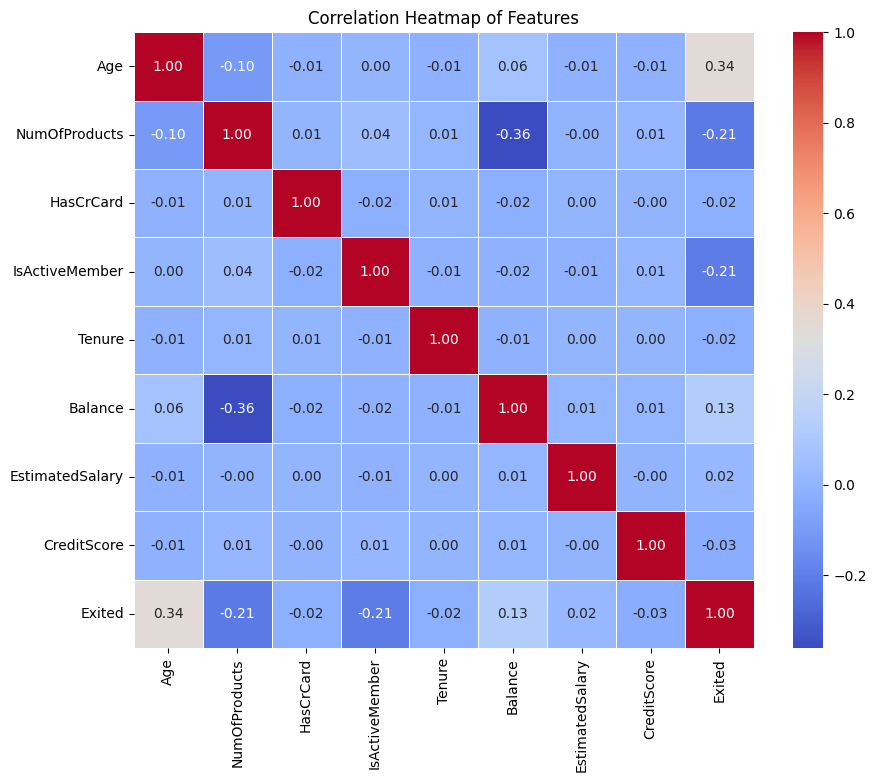

In [10]:
features_heat_num = ['Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure', 'Balance', 'EstimatedSalary', 'CreditScore', 'Exited']

corr_features = train_df[features_heat_num].corr()


plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_features, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# １．顧客情報

In [11]:

def plot_histograms(train_df, col, bins=100):
    target = 'Exited'

    bins = np.linspace(train_df[col].min(), train_df[col].max(), bins)

    data_all = train_df[col]
    data_exited_0 = train_df[train_df[target] == 0][col]
    data_exited_1 = train_df[train_df[target] == 1][col]
    
    plt.figure(figsize=(12, 6))
    plt.hist(data_all, bins=bins, alpha=0.5, color='green', label='All Data', density=False, edgecolor='black')
    plt.hist(data_exited_0, bins=bins, alpha=0.5, color='blue', label='Exited: 0', density=False, edgecolor='black')
    plt.hist(data_exited_1, bins=bins, alpha=0.5, color='orange', label='Exited: 1', density=False, edgecolor='black')

    plt.xlim(train_df[col].min(), train_df[col].max())
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col} by Exited')
    plt.legend()
    plt.show()

def barplots(train_df, col):
    target = 'Exited'

    unique_values = train_df[col].nunique()
    counts_exited_0 = train_df[train_df[target] == 0][col].value_counts().sort_index()
    counts_exited_1 = train_df[train_df[target] == 1][col].value_counts().sort_index()

    bar_width = 0.35
    indices = np.arange(len(counts_exited_0))

    plt.figure(figsize=(8, 6))
    plt.bar(indices, counts_exited_0, bar_width, label='Exited: 0', color='blue', edgecolor='black')
    plt.bar(indices + bar_width, counts_exited_1, bar_width, label='Exited: 1', color='orange', edgecolor='black')

    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Bar Chart of {col} by Exited')
    plt.xticks(indices + bar_width / 2, counts_exited_0.index)
    plt.legend()
    plt.show()

# def astype_to_float(train_df, test_df, col):
#     if train_df[col].dtype == 'object':
#         train_df[col] = train_df[col].astype(float)
#         test_df[col] = test_df[col].astype(float)

def label_encoding(train_df, test_df, col):
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.fit_transform(test_df[col])

def crosstab_df(col):
    crosstab = pd.crosstab(train_df[col], train_df['Exited'])
    crosstab['Exited_1_ratio'] = crosstab[1] / (crosstab[0] + crosstab[1])
    return crosstab

def category_and_category(col1, col2):
    train_df[col1+"_"+col2] = train_df[col1].astype(str) + '_' + train_df[col2].astype(str)
    train_df[col1+"_"+col2] = train_df[col1+"_"+col2].astype('category')
    test_df[col1+"_"+col2] = test_df[col1].astype(str) + '_' + test_df[col2].astype(str)
    test_df[col1+"_"+col2] = test_df[col1+"_"+col2].astype('category')

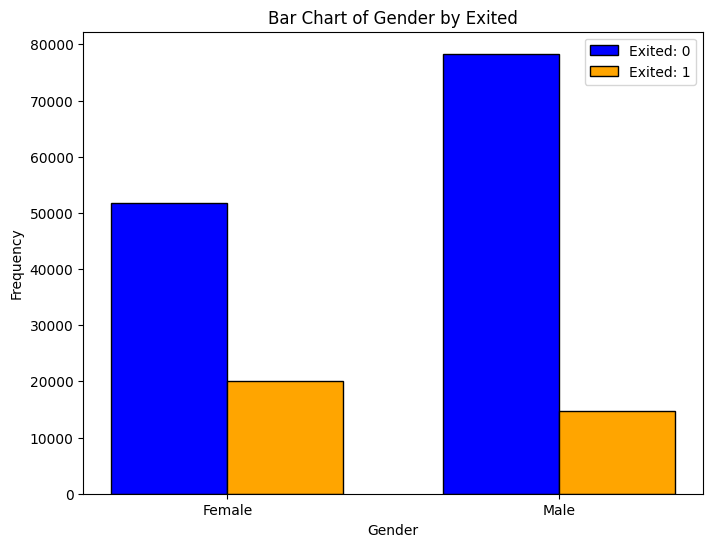

Exited,0,1,Exited_1_ratio
Gender,,,
Female,51779,20105,0.279687
Male,78334,14816,0.159055


In [12]:
# 'Geography' (0:Female, 1:Male)
label_encoding(train_df, test_df, 'Gender')
barplots(train_df, 'Gender')
crosstab_df('Gender')

女性の方が解約率が高い。十分に特徴量をして扱えるはず。

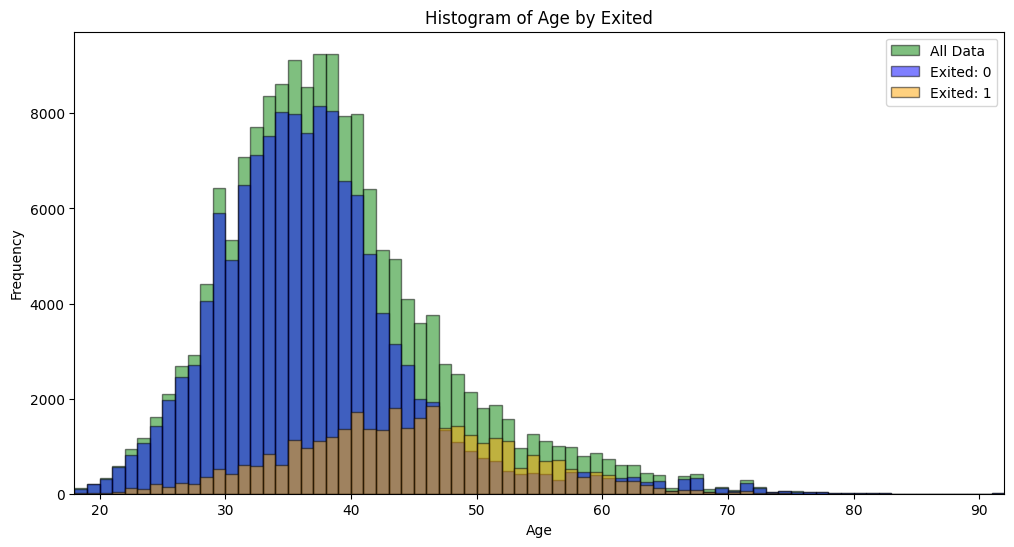

count    165034.0
mean          NaN
std           0.0
min          18.0
25%          32.0
50%          37.0
75%          42.0
max          92.0
Name: Age, dtype: float64

In [13]:
plot_histograms(train_df, 'Age', bins=75) # 1歳ごと
train_df['Age'].describe()

＜考察＞
* 中年世代が比較的高い解約数となっている。
* 特に、50〜60代前後は解約していない人も少ない。
* 年代ごとに傾向が異なるので、ビンニングもありか。
* 最大値94はありえない数字ではないので、外れ値の設定はなし。

In [14]:
bins = [10, 30, 40, 50, 60, 70, 80, 100]
labels = ['10-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-99']

# bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
# labels = ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94']

train_df['Age'] = train_df['Age'].astype(int)
test_df['Age'] = test_df['Age'].astype(int)

train_df['Age_group'] = pd.cut(train_df['Age'], bins=bins, labels=labels, right=False)
test_df['Age_group'] = pd.cut(test_df['Age'], bins=bins, labels=labels, right=False)

crosstab_df('Age_group')

Exited,0,1,Exited_1_ratio
Age_group,,,
10-29,21568,1966,0.083539
30-39,72454,8799,0.108291
40-49,28244,15075,0.348000
50-59,4760,7426,0.609388
60-69,2400,1520,0.387755
70-79,635,128,0.167759
80-99,52,7,0.118644


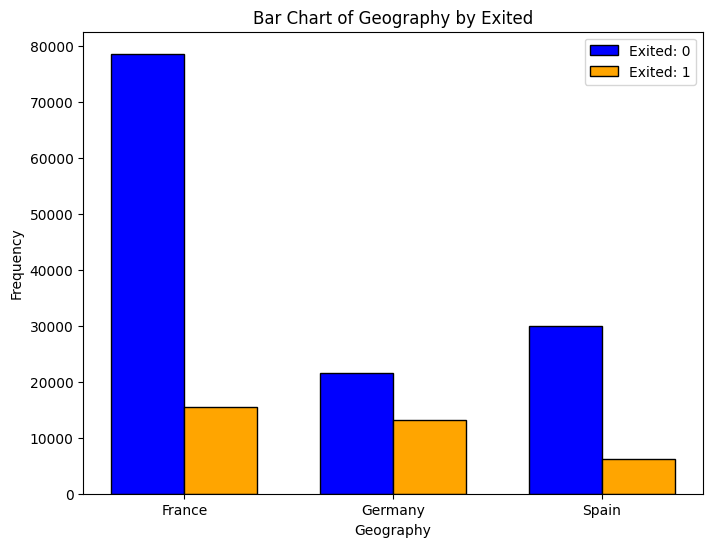

Exited,0,1,Exited_1_ratio
Geography,,,
France,78643,15572,0.165282
Germany,21492,13114,0.378952
Spain,29978,6235,0.172176


In [15]:
# Geography
label_encoding(train_df, test_df, 'Geography')
barplots(train_df, 'Geography')
crosstab_df('Geography')

In [16]:
crosstab_df('Geography')

Exited,0,1,Exited_1_ratio
Geography,,,
France,78643,15572,0.165282
Germany,21492,13114,0.378952
Spain,29978,6235,0.172176


＜考察＞

* ドイツの解約率が高いことで差別化できている。
* フランスとスペインはほぼ同等だが、デン帯におけるフランスの割合が高いなど、差異はあるので特徴量に追加する。

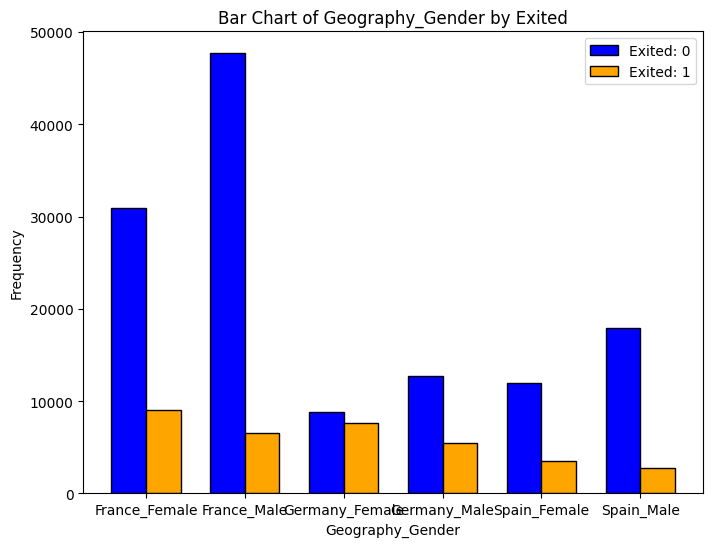

Exited,0,1,Exited_1_ratio
Geography_Gender,,,
France_Female,30974,9002,0.225185
France_Male,47669,6570,0.121131
Germany_Female,8792,7596,0.463510
Germany_Male,12700,5518,0.302887
Spain_Female,12013,3507,0.225966
Spain_Male,17965,2728,0.131832


In [17]:
category_and_category('Geography', 'Gender')
barplots(train_df, 'Geography_Gender')
crosstab_df('Geography_Gender')

# ２．銀行の情報

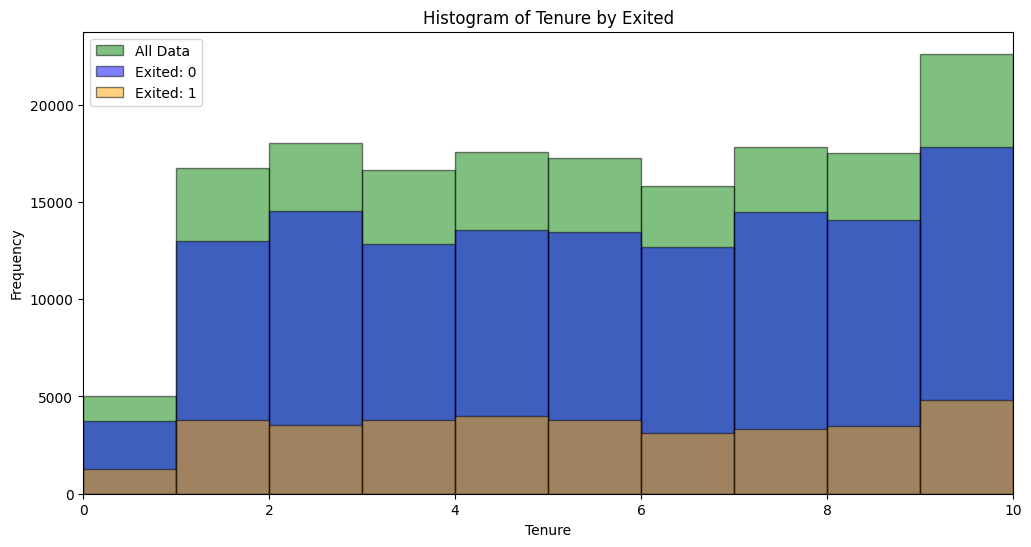

Exited,0,1,Exited_1_ratio
Tenure,,,
0,3731,1276,0.254843
1,12970,3790,0.226134
2,14529,3516,0.194846
3,12820,3810,0.229104
4,13580,3974,0.226387
5,13468,3800,0.220060
6,12677,3145,0.198774
7,14469,3341,0.187591
8,14052,3468,0.197945


In [18]:
# Tenure
plot_histograms(train_df, 'Tenure', bins=11)
crosstab_df('Tenure')

＜考察＞
* 思っていたより解約率に影響しないパラメータだった。加工してからデータに投入したい。
* 他のカラムと相関があるかもしれない。特に'Age'カラムとの相関がないか検討したい。

＜仮説メモ＞
* データのままで6〜8年の人は解約率が低い。➡️カラムをそのまま入れてみる。
* 6〜8年の人は20代前半で開設して20代後半から30代前半（解約率の低い）である影響が出ているのかも。➡️口座開設の年齢を算出する

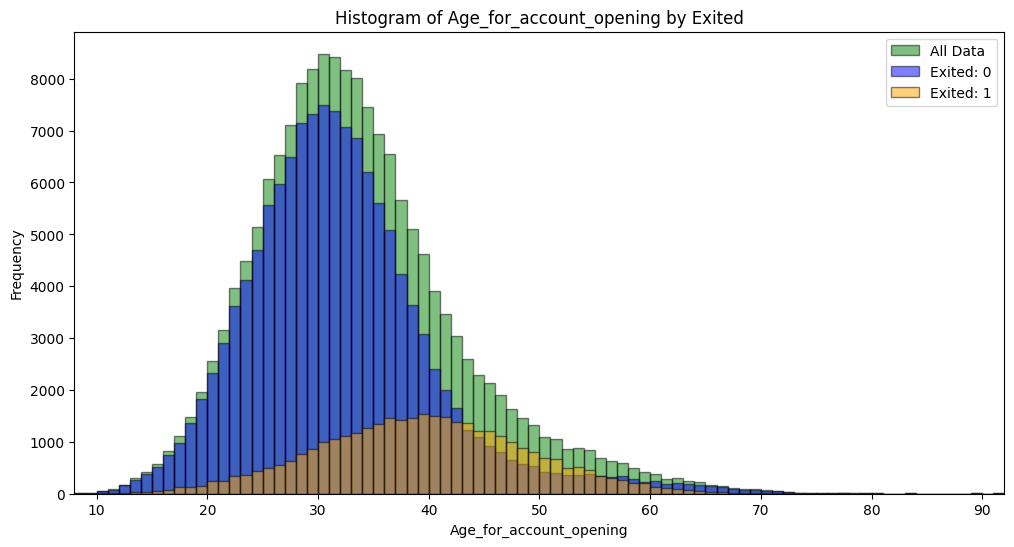

In [19]:
train_df['Age_for_account_opening'] = train_df['Age'] - train_df['Tenure']
test_df['Age_for_account_opening'] = test_df['Age'] - test_df['Tenure']

plot_histograms(train_df, 'Age_for_account_opening', bins=85) # 1歳ごと

＜考察＞
* 18歳以下でも口座開設できている理由が不明だが、特徴量としては精度向上にはならなかった。

In [20]:
# ビンの範囲を設定
bins = [10, 20, 30, 40, 50, 60, 70, 80, 100]
labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-99']


train_df['Age_for_account_opening'] = train_df['Age_for_account_opening'].astype(int)
test_df['Age_for_account_opening'] = test_df['Age_for_account_opening'].astype(int)

# pd.cut()を使って年齢をビンに分ける
train_df['Age_for_account_opening_group'] = pd.cut(train_df['Age_for_account_opening'], bins=bins, labels=labels, right=False)
test_df['Age_for_account_opening_group'] = pd.cut(test_df['Age_for_account_opening'], bins=bins, labels=labels, right=False)
crosstab_df('Age_for_account_opening_group')

Exited,0,1,Exited_1_ratio
Age_for_account_opening_group,,,
10-19,6378,578,0.083094
20-29,50156,4905,0.089083
30-39,56603,12807,0.184512
40-49,11819,11919,0.502106
50-59,3429,4125,0.546068
60-69,1482,552,0.271386
70-79,208,32,0.133333
80-99,20,1,0.047619


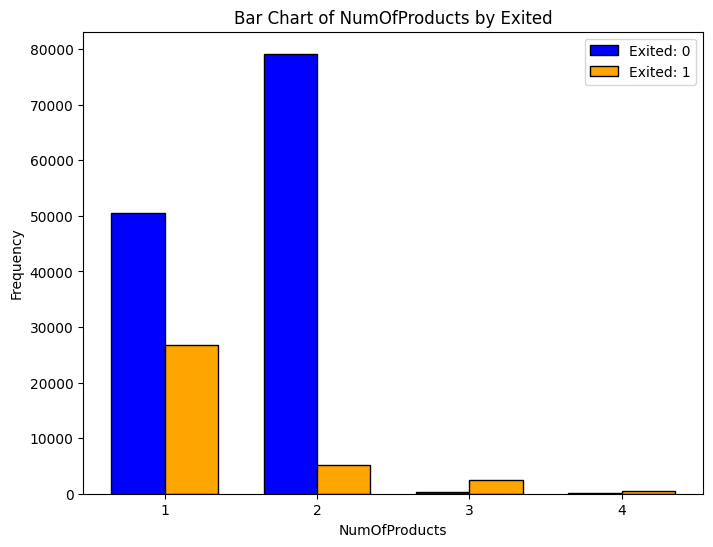

Exited,0,1,Exited_1_ratio
NumOfProducts,,,
1,50516,26858,0.347119
2,79198,5093,0.060422
3,340,2554,0.882516
4,59,416,0.875789


In [21]:
# NumOfProducts
barplots(train_df, 'NumOfProducts')
crosstab_df('NumOfProducts')

＜考察＞
* 2個持ちが解約率がかなり低い。
* 1個だけや3個以上になると解約率が多くなる。

In [22]:
# カテゴリ変数へ
bins = [1, 2, 3, 4, 5]
labels = ['One', 'Two', 'Three', 'Four']
train_df['NumOfProducts_category'] =  pd.cut(train_df['NumOfProducts'], bins=bins, labels=labels, right=False)
crosstab_df('NumOfProducts_category')

Exited,0,1,Exited_1_ratio
NumOfProducts_category,,,
One,50516,26858,0.347119
Two,79198,5093,0.060422
Three,340,2554,0.882516
Four,59,416,0.875789


In [23]:
# `Exited`の割合でエンコーディング
category_exit_ratio = train_df.groupby('NumOfProducts_category')['Exited'].mean()
train_df['NumOfProducts_ratio'] = train_df['NumOfProducts_category'].map(category_exit_ratio)

エンコーディング方法を変更しても、精度に全く影響しなかった。

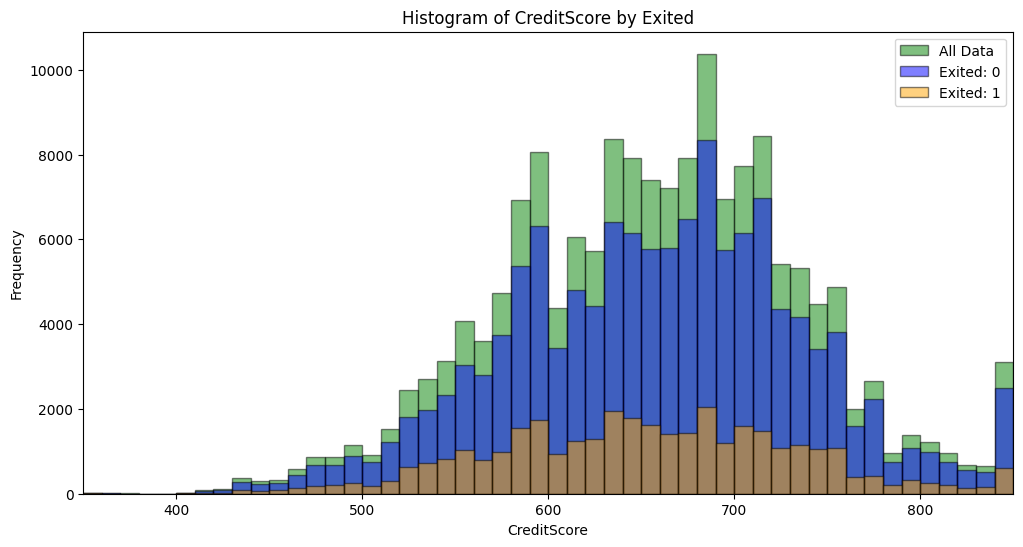

In [24]:
plot_histograms(train_df, 'CreditScore', bins=51)

In [25]:
train_df['CreditScore_and_age'] = train_df['CreditScore'] * train_df['Age']
train_df['CreditScore_per_age'] = train_df['CreditScore'] / train_df['Age']
train_df['CreditScore2_per_age'] = train_df['CreditScore'] **2  / train_df['Age']
train_df['CreditScore_per_age2'] = train_df['CreditScore'] **2  / train_df['Age']**2

test_df['CreditScore_and_age'] = test_df['CreditScore'] * test_df['Age']
test_df['CreditScore_per_age'] = test_df['CreditScore'] / test_df['Age']
test_df['CreditScore2_per_age'] = test_df['CreditScore'] **2  / test_df['Age']
test_df['CreditScore_per_age2'] = test_df['CreditScore'] **2  / test_df['Age']**2

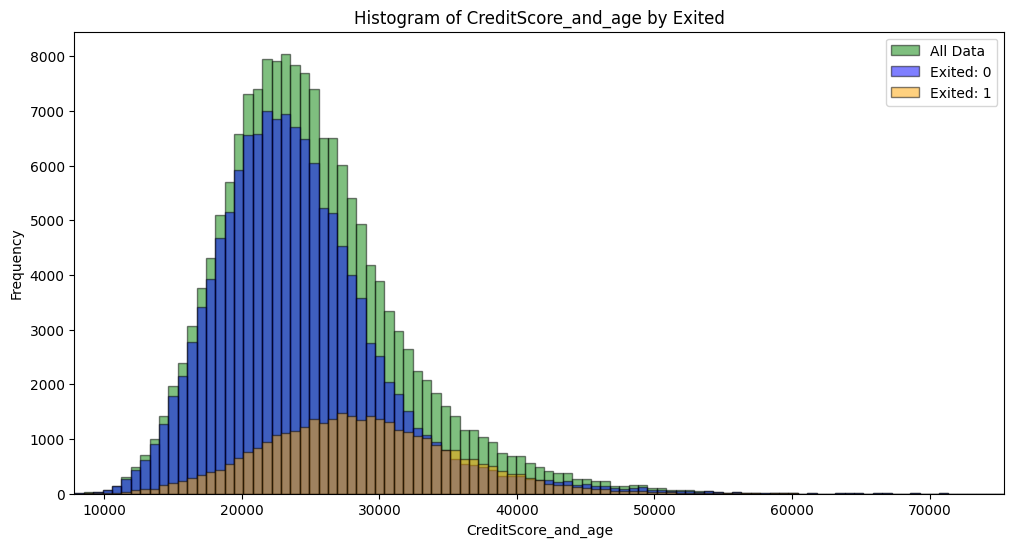

In [26]:
plot_histograms(train_df, 'CreditScore_and_age', bins=100)

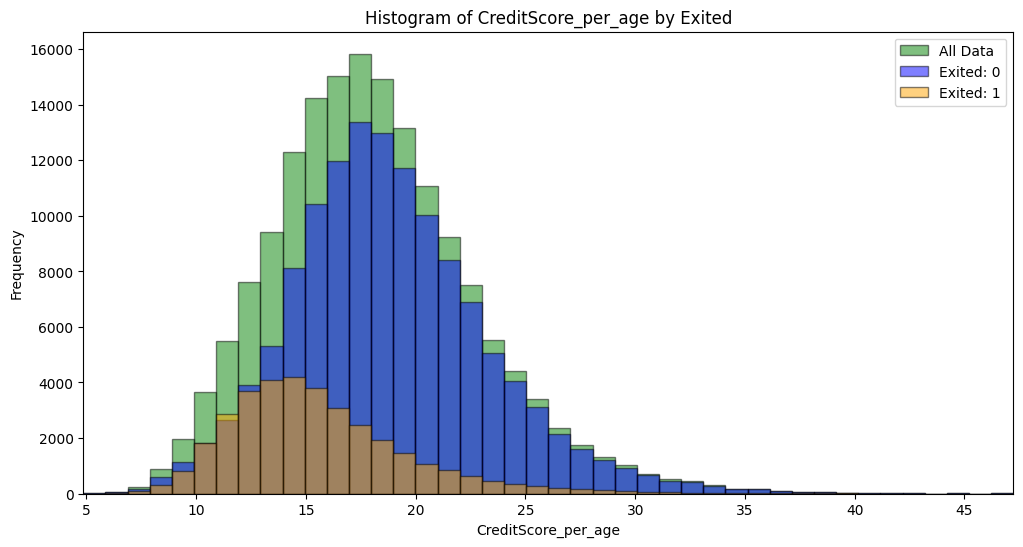

In [27]:
plot_histograms(train_df, 'CreditScore_per_age', bins=43)

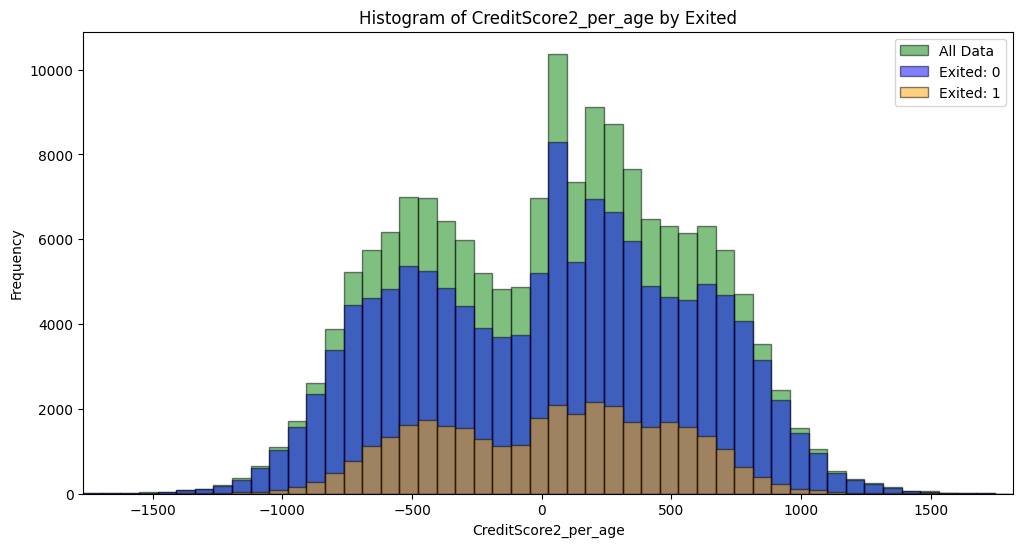

In [28]:
plot_histograms(train_df, 'CreditScore2_per_age', bins=51)

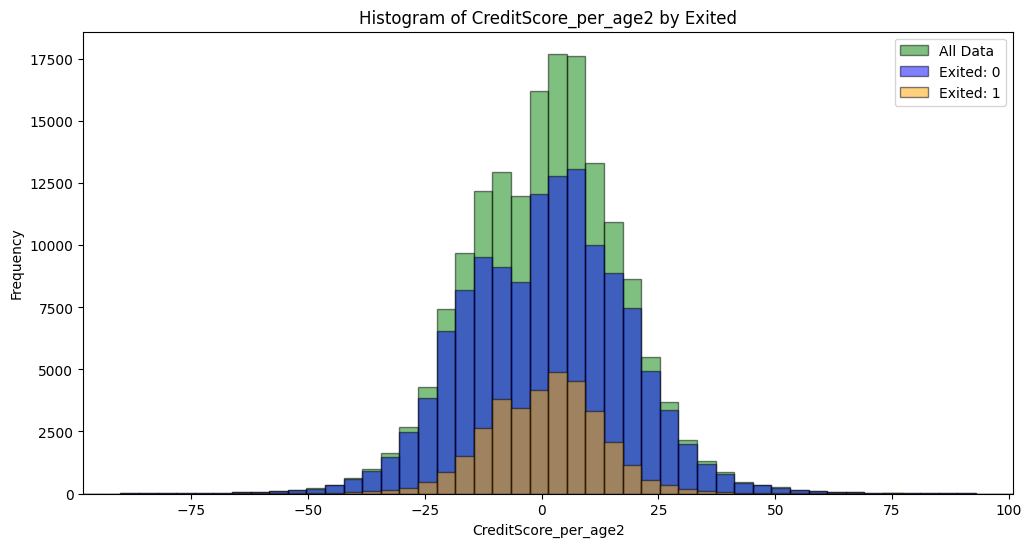

In [29]:
plot_histograms(train_df, 'CreditScore_per_age2', bins=51)

＜考察＞
* 信用スコアで見たとき、まばらだが若干の特徴あり。特徴量として入れてみる。

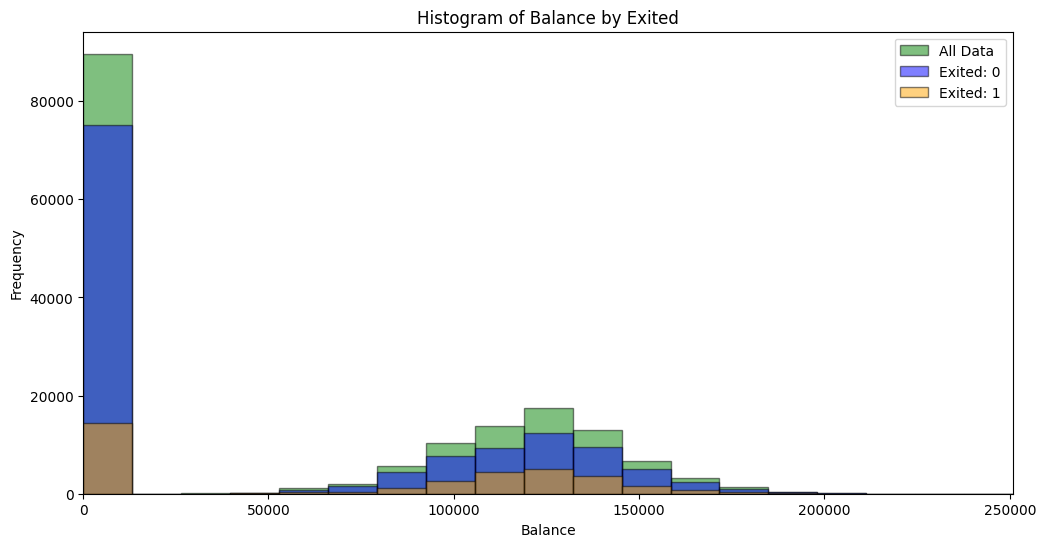

count    165034.000000
mean      55478.085938
std       62817.664062
min           0.000000
25%           0.000000
50%           0.000000
75%      119939.519531
max      250898.093750
Name: Balance, dtype: float64

In [30]:
plot_histograms(train_df, 'Balance', bins=20)
train_df['Balance'].describe()

＜考察＞
* 口座の残額が0である人が大多数。➡️残高０をターゲットエンコーディングする。
* それ以外の範囲は、解約の傾向は薄い。➡
* 口座あたりの残高のカラムも作ってみる

In [31]:
train_df['Balance_is_zero'] = np.where(train_df['Balance'] == 0, 1, 0)
test_df['Balance_is_zero'] = np.where(test_df['Balance'] == 0, 1, 0)
train_df['Balance_is_zero'].sum()

89648

＜考察＞
* 残高ゼロのフラグを付けても、重要度がかなり低く精度改善にならなかった。元のカラムで説明がついていそう。

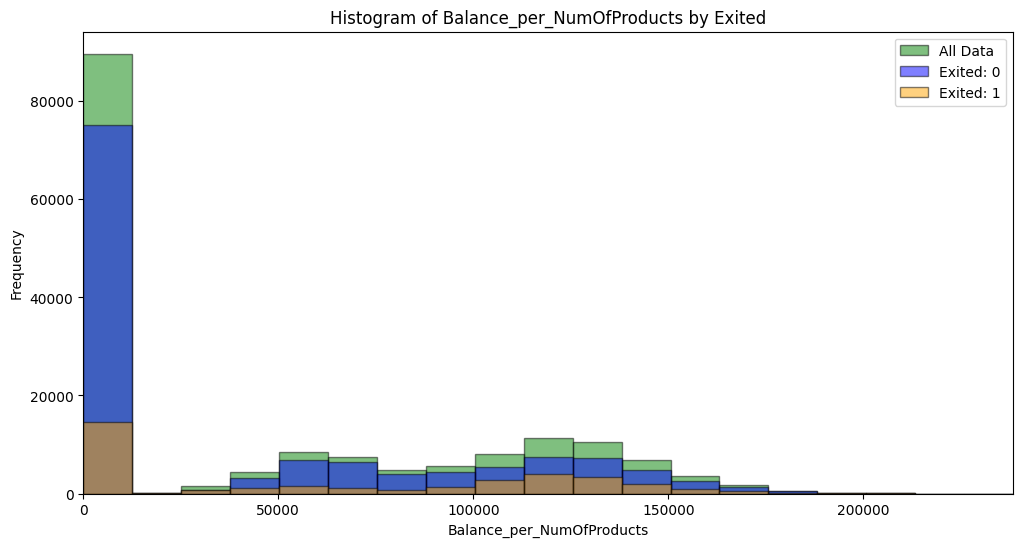

In [32]:
train_df['Balance_per_NumOfProducts'] = train_df['Balance'] / train_df['NumOfProducts']
test_df['Balance_per_NumOfProducts'] = test_df['Balance'] / test_df['NumOfProducts']
plot_histograms(train_df, 'Balance_per_NumOfProducts', bins=20)

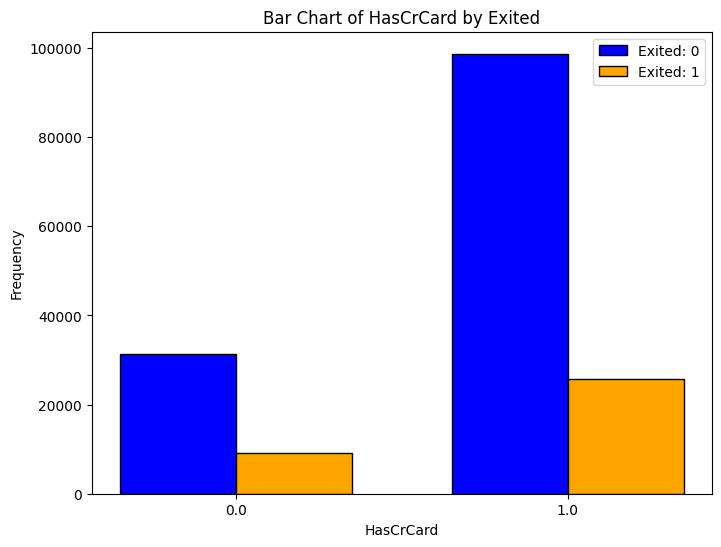

Exited,0,1,Exited_1_ratio
HasCrCard,,,
0,31371,9235,0.227429
1,98742,25686,0.206433


In [33]:
# HasCrCard
barplots(train_df, 'HasCrCard')

train_df['HasCrCard'] = train_df['HasCrCard'].astype(int)
test_df['HasCrCard'] = test_df['HasCrCard'].astype(int)
crosstab_df('HasCrCard')

＜考察＞
* 若干の違いあり。特徴量に入れつつ確認する。

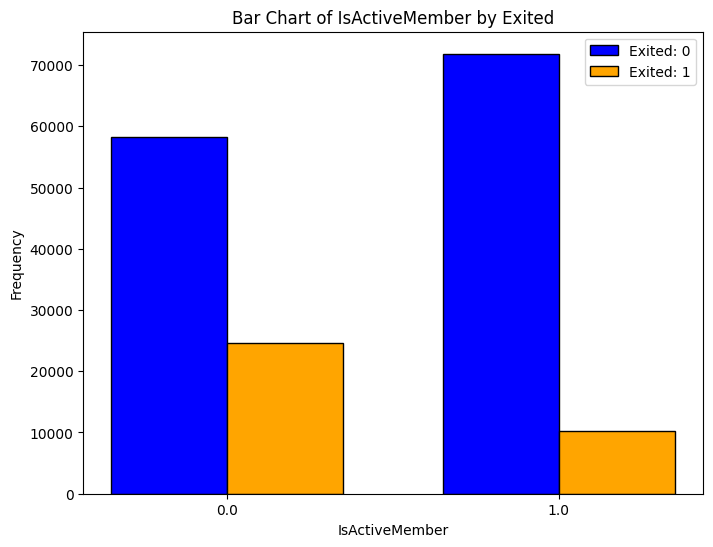

Exited,0,1,Exited_1_ratio
IsActiveMember,,,
0,58261,24624,0.297086
1,71852,10297,0.125345


In [34]:
# IsActiveMember
barplots(train_df, 'IsActiveMember')

train_df['IsActiveMember'] = train_df['IsActiveMember'].astype(int)
test_df['IsActiveMember'] = test_df['IsActiveMember'].astype(int)
crosstab_df('IsActiveMember')

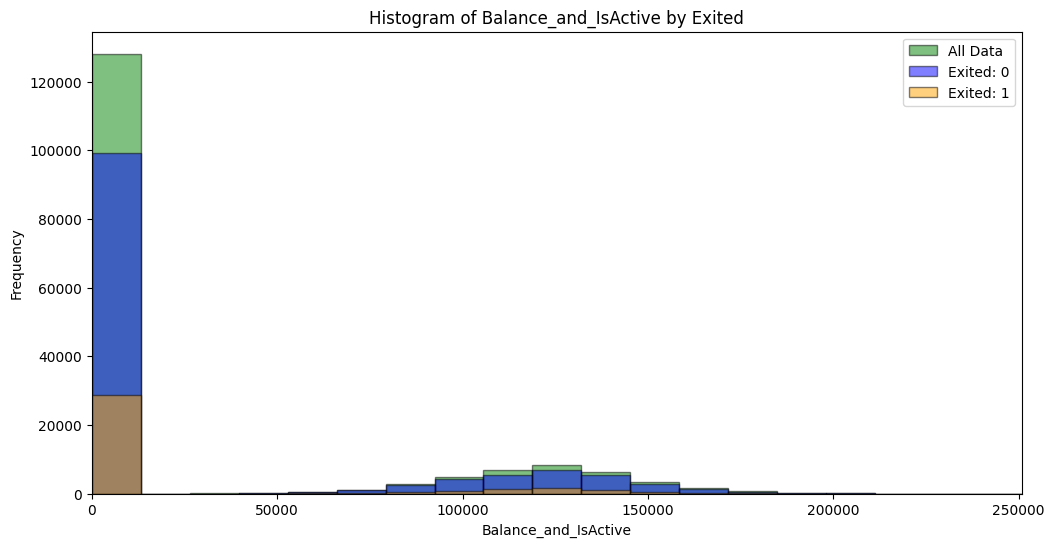

In [35]:
train_df['Balance_and_IsActive'] = train_df['Balance'] * train_df['IsActiveMember']
train_df['Balance_and_IsActive'] = train_df['Balance'] * train_df['IsActiveMember']
plot_histograms(train_df, 'Balance_and_IsActive', bins=20)

＜考察＞
* 会員状態がアクティブになっていない人ほど解約率が高い。
* 会員で残高が０の場合はどうなるのか。

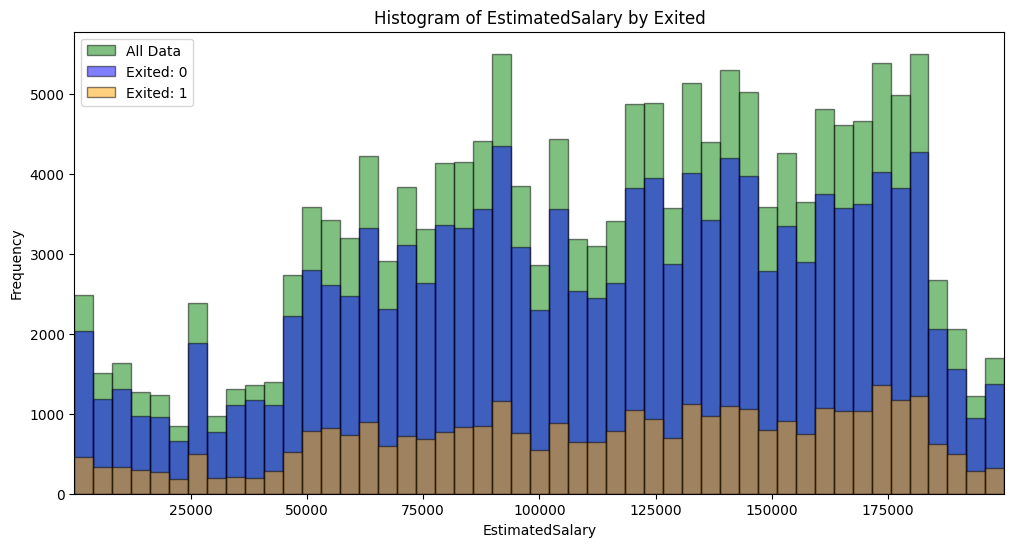

In [36]:
# EstimatedSalary
plot_histograms(train_df, 'EstimatedSalary', bins=50)

＜考察＞
* 特徴的にはまばらになっている。
* サラリーに占める貯金額でメイン口座かどうかを把握できそう。サブだと解約率が高そう。

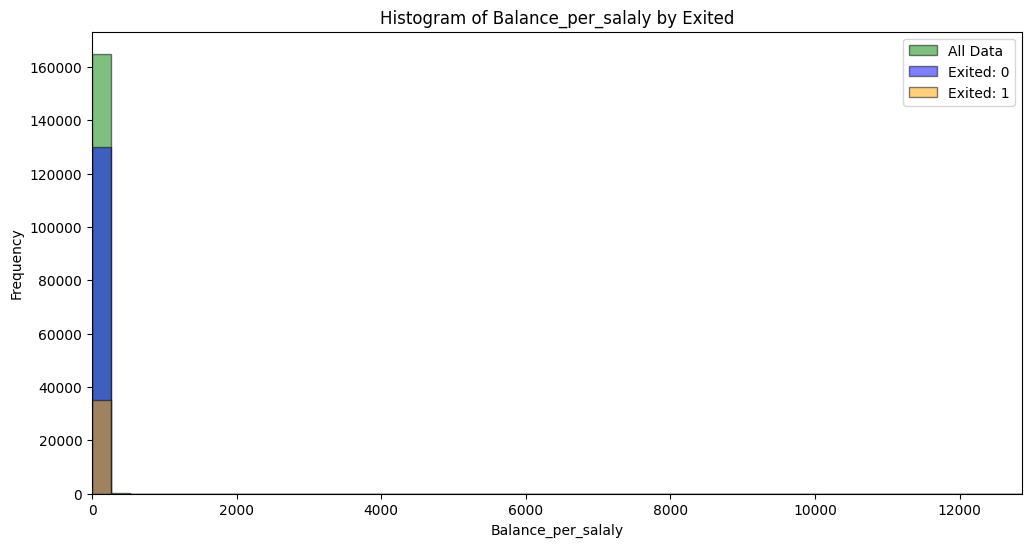

count    165034.000000
mean          2.100904
std          91.642448
min           0.000000
25%           0.000000
50%           0.000000
75%           0.978816
max       12863.796875
Name: Balance_per_salaly, dtype: float64

In [37]:
train_df['Balance_per_salaly'] = train_df['Balance'] / train_df['EstimatedSalary']
test_df['Balance_per_salaly'] = test_df['Balance'] / test_df['EstimatedSalary']
plot_histograms(train_df, 'Balance_per_salaly', bins=50)
train_df['Balance_per_salaly'].describe()

In [38]:
train_df['Salary_per_CreditScore'] = train_df['EstimatedSalary'] / train_df['CreditScore']
train_df['Salary_and_CreditScore'] = train_df['EstimatedSalary'] * train_df['CreditScore']
test_df['Salary_per_CreditScore'] = test_df['EstimatedSalary'] / test_df['CreditScore']
test_df['Salary_and_CreditScore'] = test_df['EstimatedSalary'] * test_df['CreditScore']

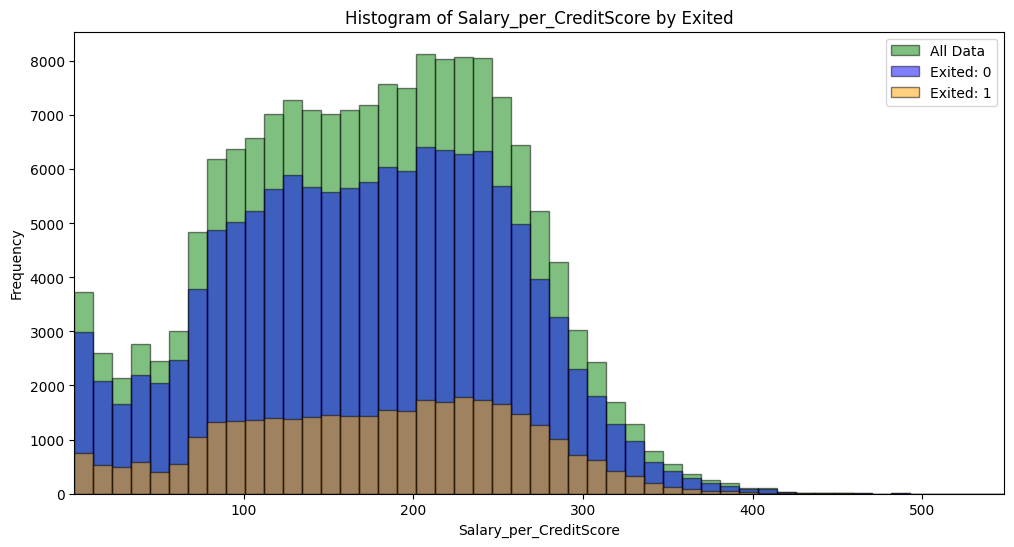

In [39]:
plot_histograms(train_df, 'Salary_per_CreditScore', bins=50)

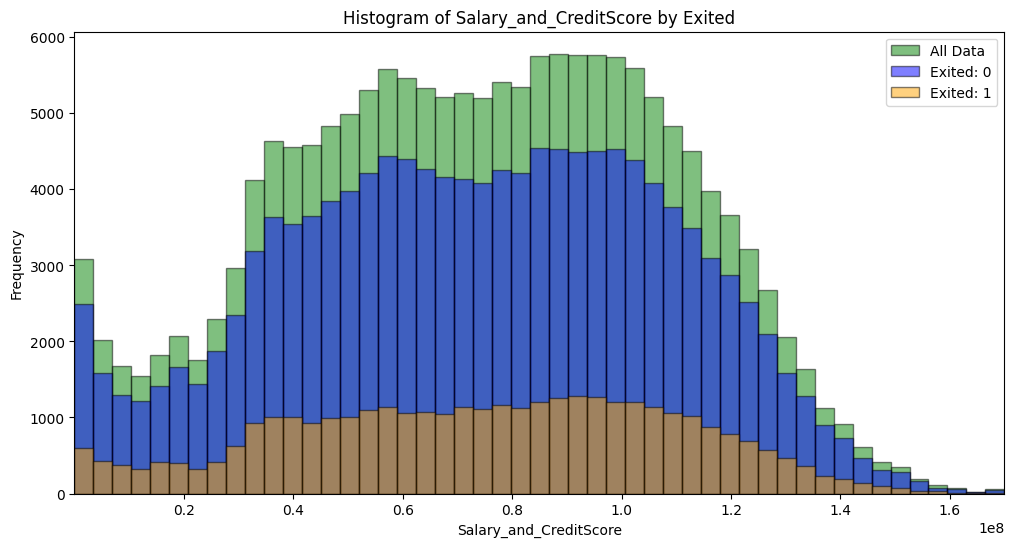

In [40]:
plot_histograms(train_df, 'Salary_and_CreditScore', bins=50)

In [41]:
train_df['Salary_per_Age'] = train_df['EstimatedSalary'] / train_df['Age']
train_df['Salary_per_Age2'] = train_df['EstimatedSalary'] / train_df['Age']**2

test_df['Salary_per_Age'] = test_df['EstimatedSalary'] / test_df['Age']
test_df['Salary_per_Age2'] = test_df['EstimatedSalary'] / test_df['Age']**2

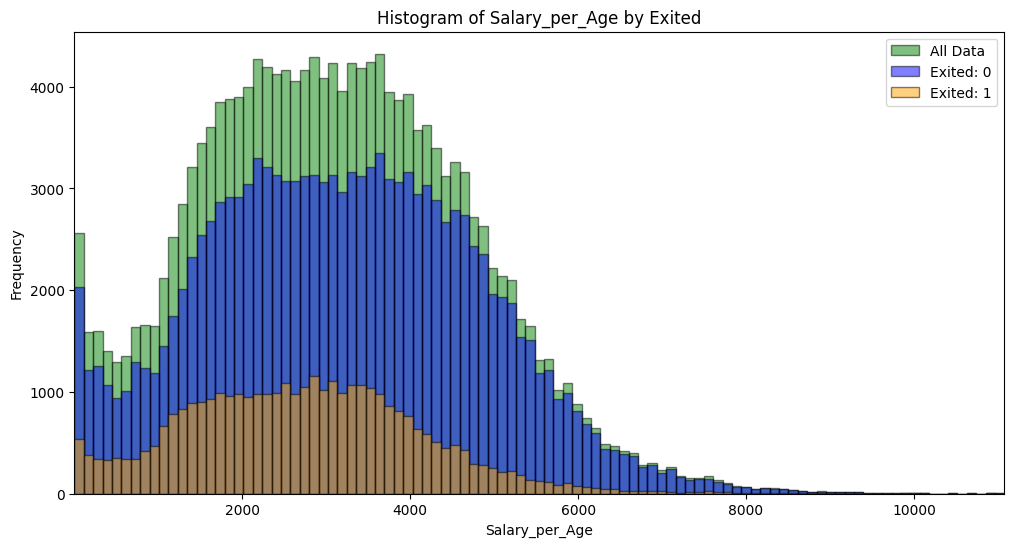

In [42]:
plot_histograms(train_df, 'Salary_per_Age', bins=100)

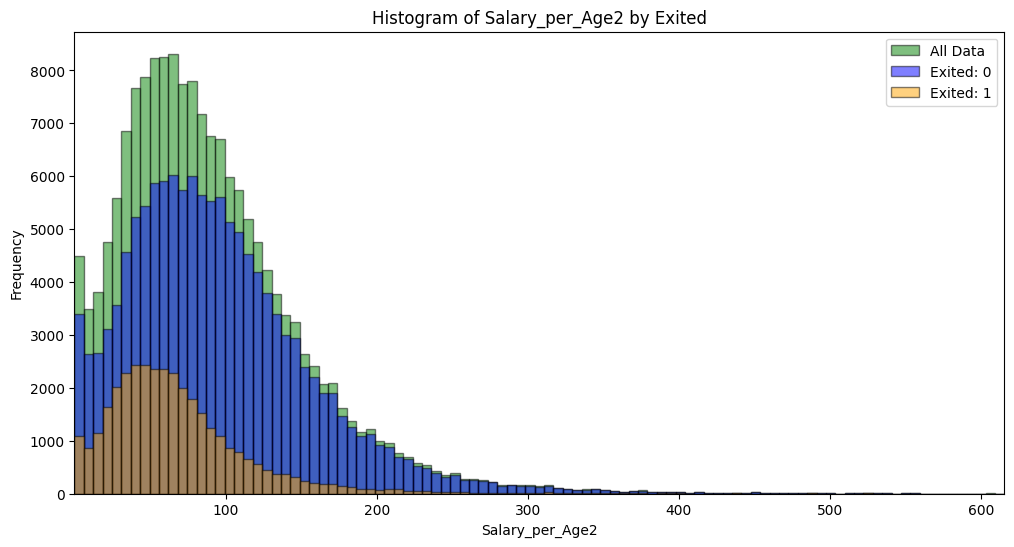

In [43]:
plot_histograms(train_df, 'Salary_per_Age2', bins=100)

# モデル用データセット

In [44]:
features = [
    # customer
    'Age', 'Age_group',
    'Geography','Gender',
    'Geography_Gender',
    # bank
    'HasCrCard','NumOfProducts', 'IsActiveMember', 'Tenure', 'CreditScore',
    # 'CreditScore_and_age', 
    'CreditScore_per_age', 
    # 'CreditScore2_per_age', 'CreditScore_per_age2',
    'Age_for_account_opening_group', 
    'Balance_per_NumOfProducts',
    'Salary_per_CreditScore', 
    # 'Salary_and_CreditScore', 
    'Salary_per_Age', 
    # 'Salary_per_Age2'
]

x_train = train_df[features]
y_train = train_df['Exited']

In [45]:
x_tr, x_va, y_tr, y_va = train_test_split(
    x_train,
    y_train,
    shuffle=True,
    test_size=0.2,
    stratify=y_train,
    random_state=123
)

print(x_tr.shape)  # 特徴量の形状を確認
print(y_tr.shape)  # ターゲットの形状を確認

(132027, 15)
(132027,)


# モデル試作

In [46]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'random_state': 123,
    'num_leaves': 16,
    'n_estimators': 1000,
    'importance_type': 'gain',
    'verbose': -1,
    'min_data_in_leaf': 100,
    'max_depth': 5,
    'lambda_l1': 0.1,    
    'lambda_l2': 0.5,
    'feature_fraction': 0.6, 
    'bagging_fraction': 0.6, 
    'bagging_freq': 4,
}

In [47]:
model = lgb.LGBMClassifier(**params)
model.fit(
    x_tr, y_tr,
    eval_set= [(x_tr, y_tr), (x_va, y_va)],
    callbacks=[
        lgb.callback.early_stopping(stopping_rounds=100),
        lgb.callback.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.890429	valid_1's auc: 0.886652
[200]	training's auc: 0.893196	valid_1's auc: 0.887729
[300]	training's auc: 0.895194	valid_1's auc: 0.888124
[400]	training's auc: 0.896926	valid_1's auc: 0.888217
[500]	training's auc: 0.898458	valid_1's auc: 0.888205
Early stopping, best iteration is:
[440]	training's auc: 0.897566	valid_1's auc: 0.888266


LGBMClassifier(bagging_fraction=0.6, bagging_freq=4, feature_fraction=0.6,
               importance_type='gain', lambda_l1=0.1, lambda_l2=0.5,
               learning_rate=0.05, max_depth=5, metric='auc',
               min_data_in_leaf=100, n_estimators=1000, num_leaves=16,
               objective='binary', random_state=123, verbose=-1)

In [48]:
y_tr_pred = model.predict_proba(x_tr)[:, 1]
y_va_pred = model.predict_proba(x_va)[:, 1]

metric_tr = roc_auc_score(y_tr, y_tr_pred)
metric_va = roc_auc_score(y_va, y_va_pred)

print("Tr:", metric_tr)
print("Va:", metric_va)

Tr: 0.8975660064688664
Va: 0.8882658058368402


# クロスバリデーション

In [49]:
metric=[]
imp=pd.DataFrame()
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

for nfold, (train_index, val_index) in enumerate(cv.split(x_train, y_train)):
    print('-'*20, nfold, '-'*20)
    x_tr, y_tr = x_train.iloc[train_index], y_train.iloc[train_index]
    x_va, y_va = x_train.iloc[val_index], y_train.iloc[val_index]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        x_tr, y_tr,
        eval_set= [(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100)
        ]
    )
    
    y_tr_pred = model.predict_proba(x_tr)[:, 1]
    y_va_pred = model.predict_proba(x_va)[:, 1]
    
    metric_tr = roc_auc_score(y_tr, y_tr_pred)
    metric_va = roc_auc_score(y_va, y_va_pred)

    metric.append((nfold, metric_tr, metric_va))
    
    print("Tr:", metric_tr)
    print("Va:", metric_va)
    
    _imp = pd.DataFrame({
        'col': x_train.columns,
        'imp': model.feature_importances_,
        'fold': nfold
    })
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print('-'*50)
print(pd.DataFrame(metric, columns=["Fold", "Train", "Va"]))
print('-'*50)

metric = np.array(metric)
print('[tr]: {:3f}+-{:2f}'.format(metric[:, 1].mean(), metric[:, 1].std()), '[va]: {:3f}+-{:2f}'.format(metric[:, 2].mean(), metric[:, 2].std()))

-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.890351	valid_1's auc: 0.886773
[200]	training's auc: 0.893228	valid_1's auc: 0.887732
[300]	training's auc: 0.895218	valid_1's auc: 0.887975
[400]	training's auc: 0.896874	valid_1's auc: 0.888006
[500]	training's auc: 0.89829	valid_1's auc: 0.887941
Early stopping, best iteration is:
[452]	training's auc: 0.897653	valid_1's auc: 0.888109
Tr: 0.8976533657504429
Va: 0.88810867602406
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.889569	valid_1's auc: 0.890013
[200]	training's auc: 0.89246	valid_1's auc: 0.890835
[300]	training's auc: 0.894556	valid_1's auc: 0.891013
Early stopping, best iteration is:
[265]	training's auc: 0.893898	valid_1's auc: 0.891096
Tr: 0.8938977849482665
Va: 0.8910956775878806
-------------------- 2 --------------------
Training until validation scores don

In [50]:
imp_df = imp.groupby('col')['imp'].agg(['mean', 'std'])
imp_df.columns = ['imp', 'imp_std']
imp_df.reset_index(drop=False)
imp_df.sort_values('imp', ascending=False)

,imp,imp_std
col,,
NumOfProducts,116529.451605,1236.246920
Age,97335.144549,1616.198890
IsActiveMember,32795.881636,251.424787
Balance_per_NumOfProducts,21506.227290,1060.028190
Age_group,17931.211233,711.462736
Geography_Gender,17161.713110,672.409769
Geography,11616.047852,729.186645
CreditScore_per_age,7929.419307,1215.379614
CreditScore,4549.539634,1497.174176


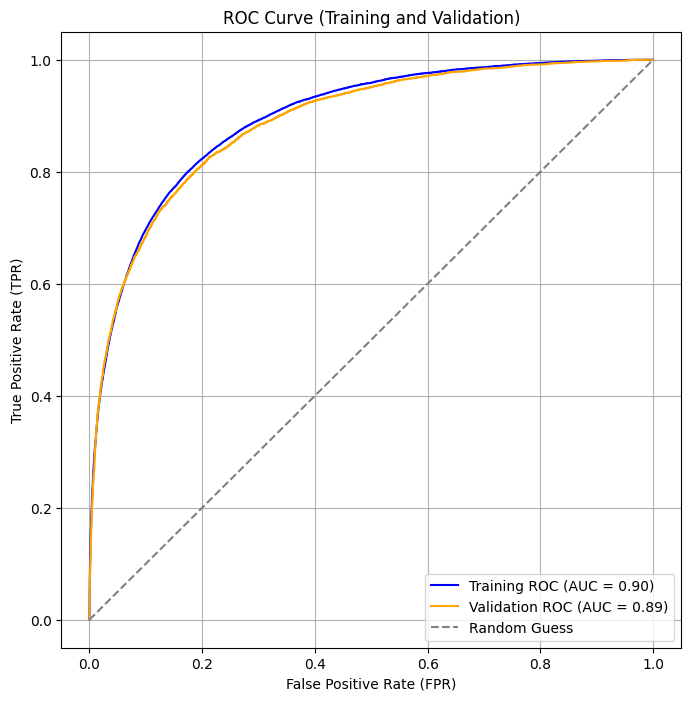

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score

y_tr_score = model.predict_proba(x_tr)[:, 1]
y_va_score = model.predict_proba(x_va)[:, 1]

fpr_tr, tpr_tr, _ = roc_curve(y_tr, y_tr_score)
auc_tr = roc_auc_score(y_tr, y_tr_score)

fpr_va, tpr_va, _ = roc_curve(y_va, y_va_score)
auc_va = roc_auc_score(y_va, y_va_score)

plt.figure(figsize=(8, 8))
plt.plot(fpr_tr, tpr_tr, label=f'Training ROC (AUC = {auc_tr:.2f})', color='blue')
plt.plot(fpr_va, tpr_va, label=f'Validation ROC (AUC = {auc_va:.2f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Training and Validation)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Optuna

In [52]:
# pip install optuna

In [53]:
# import optuna
# import gc
# import pandas as pd
# import numpy as np
# import lightgbm as lgb
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_auc_score

# # Objective function for Optuna optimization
# def objective(trial, x_train, y_train):
#     max_depth = trial.suggest_int('max_depth', 3, 12)
#     num_leaves = trial.suggest_int('num_leaves', 16, 64) if max_depth > 5 else trial.suggest_int('num_leaves', 16, 32)
#     lgbm_params = {
#         'boosting_type': 'gbdt',
#         'objective': 'binary',
#         'metric': 'auc',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-2, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-1, 10.0),
#         'num_leaves': num_leaves,
#         'max_depth': max_depth,
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 0.9),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 0.9),
#         'bagging_freq': trial.suggest_int('bagging_freq', 4, 6),
#         'min_child_samples': trial.suggest_int('min_child_samples', 50, 100),
#         'verbose': -1,
#         'learning_rate': 0.05,
#     }

#     metric = []
#     imp = pd.DataFrame()
#     n_splits = 5
#     cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

#     for nfold, (train_index, val_index) in enumerate(cv.split(x_train, y_train)):
#         print('-'*20, nfold, '-'*20)
#         x_tr, y_tr = x_train.iloc[train_index], y_train.iloc[train_index]
#         x_va, y_va = x_train.iloc[val_index], y_train.iloc[val_index]

#         model = lgb.LGBMClassifier(**lgbm_params)
#         model.fit(
#             x_tr, y_tr,
#             eval_set=[(x_tr, y_tr), (x_va, y_va)],
#             callbacks=[
#                 lgb.callback.early_stopping(stopping_rounds=100),
#                 lgb.callback.log_evaluation(period=100)
#             ]
#         )
        
#         y_tr_pred = model.predict_proba(x_tr)[:, 1]
#         y_va_pred = model.predict_proba(x_va)[:, 1]
        
#         metric_tr = roc_auc_score(y_tr, y_tr_pred)
#         metric_va = roc_auc_score(y_va, y_va_pred)

#         metric.append((nfold, metric_tr, metric_va))
        
#         print("Tr:", metric_tr)
#         print("Va:", metric_va)
        
#         _imp = pd.DataFrame({
#             'col': x_train.columns,
#             'imp': model.feature_importances_,
#             'fold': nfold
#         })
#         imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

#     print('-'*50)
#     print(pd.DataFrame(metric, columns=["Fold", "Train", "Va"]))
#     print('-'*50)

#     metric = np.array(metric)
#     print('[tr]: {:3f}+-{:2f}'.format(metric[:, 1].mean(), metric[:, 1].std()), '[va]: {:3f}+-{:2f}'.format(metric[:, 2].mean(), metric[:, 2].std()))

#     return np.mean(metric[:, 2])  # Return the validation AUC as the optimization target

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="maximize")
# study.optimize(lambda trial: objective(trial, x_train, y_train), n_trials=200)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 結果表示
# print("Best Parameters: ", study.best_params)
# print("Best Value: ", study.best_value)

# # 選択した範囲のRMSLEスコアを格納するリスト（必要に応じて）
# valid_params_with_rmsle = []

# # ここで特徴量の重要度を保存して後で分析する
# imp = imp.groupby('col').agg({'imp': 'mean'}).reset_index()
# print("Feature Importances:")
# print(imp.sort_values(by='imp', ascending=False))


In [54]:
y_pred_prob = model.predict_proba(test_df[features])[:, 1]  


sub = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
test_ids = sub['id'] 

submission = pd.DataFrame({
    'id': test_ids,
    'Exited': y_pred_prob
})

submission_name = "bank_submission5"

submission.to_csv(f'{submission_name}.csv', index=False)
submission.head()

,id,Exited
0,165034,0.025644
1,165035,0.839926
2,165036,0.024504
3,165037,0.217090
4,165038,0.321591
